# eCommerce Customer Segmentation (RFM Analysis + K-Means Clustering)


## Table of Contents

<ul>
<li><a href="#exploratory"> Data Preprocessing and Exploratory Data Analysis</a></li>
<li><a href="#rfm">RFM Analysis</a></li>
<li><a href="#segmentation1">Customer Segmentation with RFM Model</a></li>
<li><a href="#results1">Results and Interpretations of RFM Analysis</a></li>
<li><a href="#segmentation2">Customer Segmentation with K-Means Clustering</a></li>
<li><a href="#results2">Results and Interpretations of K-Means Clustering</a></li>
</ul>


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as sq
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from datetime import date as dt

%matplotlib inline

### Data Acquisition

In [93]:
df = pd.read_csv('/Users/wei-lin/Desktop/Projects/eCommerce/OnlineRetail.csv', encoding= 'unicode_escape')

<a id='exploratory'></a>
### Data Preprocessing and Exploratory Data Analysis


In [94]:
print('Shape of the dataframe: ',df.shape)
df.head()

Shape of the dataframe:  (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Data Cleansing

In [95]:
# Display rows containing missing values 

null_data = df[df.isnull().any(axis=1)]  #'any(axis=1)': Checking rows if any null values exists 
null_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01-12-2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01-12-2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01-12-2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01-12-2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01-12-2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,09-12-2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,09-12-2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,09-12-2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,09-12-2011 10:26,10.79,NaN,United Kingdom


In [96]:
print('Sum of rows having missing values: '+ str(df.isnull().sum()))

Sum of rows having missing values: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [97]:
#Drop rows have missing values and print the size of the cleaned dataset
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('Shape of the cleaned dataframe: ',df.shape)

Shape of the cleaned dataframe:  (406829, 8)


In [98]:
#Return the dtypes in the DataFrame
df.dtypes 

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [99]:
# Convert the datatype of CustomerID to string for avoiding misunderstandings
# Convert the datetime to proper datatypes (InvoiceDate)

df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

df[['CustomerID','InvoiceDate']].head()

,CustomerID,InvoiceDate
0,17850.0,2010-12-01 08:26:00
1,17850.0,2010-12-01 08:26:00
2,17850.0,2010-12-01 08:26:00
3,17850.0,2010-12-01 08:26:00
4,17850.0,2010-12-01 08:26:00


In [100]:
# Generate descriptive statistics
df.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


<a id='rfm'></a>
## RFM Analysis 

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM model helps divide customers into segments to identify customers who are more likely to respond to promotions and also for future personalized communications.

First, Create an RFM model to assign Recency, Frequency and Monetary values to each customer

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [101]:
# Attribute : Recency
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [102]:
# Compute the difference between max date and transaction date

df['Recency'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00


In [103]:
# Compute last transaction date to get the recency of customers

rfm_r = df.groupby('CustomerID')['Recency'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [104]:
# Extract only the number of days 
rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [105]:
# Attribute : Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [106]:
# Attribute : Monetary
df['Monetary'] = df['UnitPrice']*df['Quantity']
rfm_m = df.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [107]:
# Merge two dataframes (Recency and Frequency)

rfm_rf = pd.merge(rfm_r, rfm_f, on = 'CustomerID', how='inner')
rfm_rf[['CustomerID','Recency','Frequency']].head()

,CustomerID,Recency,Frequency
0,12346.0,325,2
1,12347.0,1,182
2,12348.0,74,31
3,12349.0,18,73
4,12350.0,309,17


In [108]:
# Merge all three dataframes to get the final RFM dataframe

rfm = pd.merge(rfm_rf, rfm_m, on='CustomerID', how='inner')

rfm[['CustomerID','Recency', 'Frequency', 'Monetary']].head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


### Remove outliers 

Use "__Interquartile Range Method__ " to remove outliers.

Text(0.5, 0, 'Attributes')

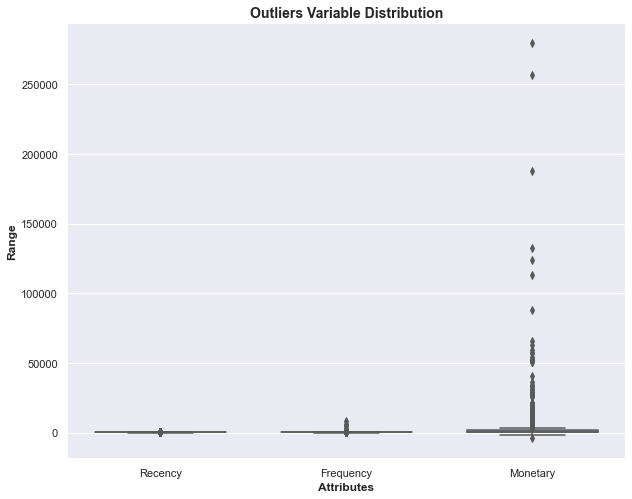

In [109]:
# Outlier Analysis of RFM ('Recency', 'Frequency' and 'Monetary')

attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [10,8]# width and height = 10 and 8
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

It is hard to see the range of Recency and Frequency; therefore, display these two attributes again.

Text(0.5, 0, 'Attributes')

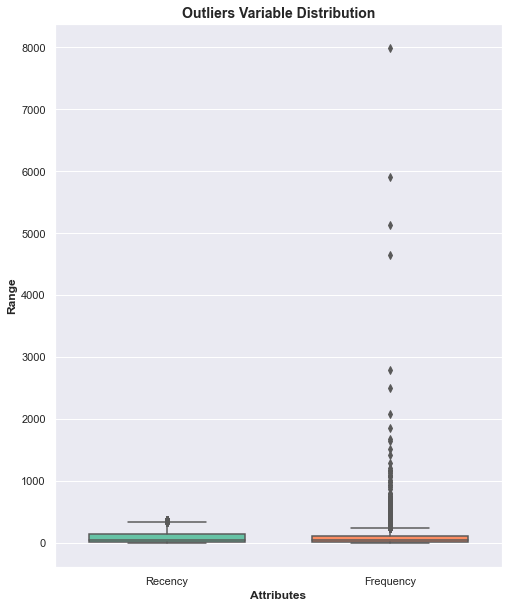

In [110]:
# Outlier Analysis of RFM ('Recency','Frequency')

attributes = ['Recency','Frequency']
plt.rcParams['figure.figsize'] = [8,10]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [111]:
# Apply Interquartile Range Method
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Monetary 
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]


Text(0.5, 0, 'Attributes')

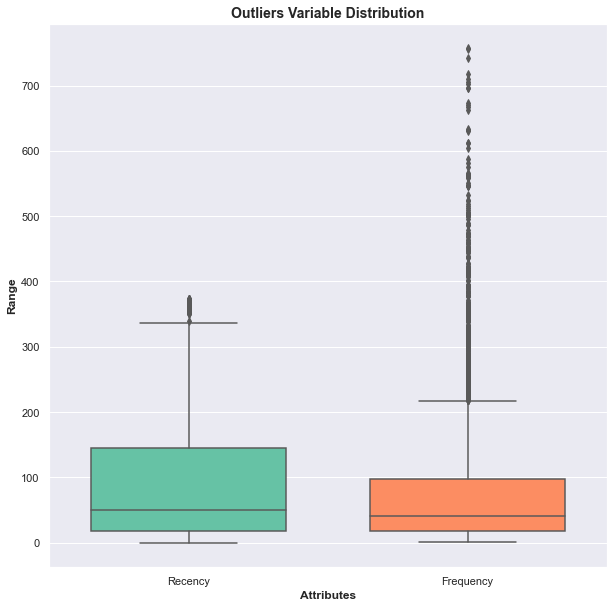

In [112]:
# Check again after removing statistical outliers, it shows outliers are removed

attributes = ['Recency','Frequency']
plt.rcParams['figure.figsize'] = [10,10]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

### RFM Table Verification

In [113]:
df[df['InvoiceNo']=='541432']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency,Monetary
61620,541432,21485,RETROSPOT HEART HOT WATER BOTTLE,3,2011-01-18 10:15:00,4.95,12748.0,United Kingdom,325 days 02:35:00,14.85
61621,541432,22457,NATURAL SLATE HEART CHALKBOARD,4,2011-01-18 10:15:00,2.95,12748.0,United Kingdom,325 days 02:35:00,11.80
61622,541432,84050,PINK HEART SHAPE EGG FRYING PAN,12,2011-01-18 10:15:00,1.65,12748.0,United Kingdom,325 days 02:35:00,19.80
61623,541432,22113,GREY HEART HOT WATER BOTTLE,30,2011-01-18 10:15:00,3.75,12748.0,United Kingdom,325 days 02:35:00,112.50


In [114]:
#df['Recency'] = max_date - df['InvoiceDate']
#df.head()

d0 = dt(2011,1,18) # trsaction data of InvoiceNo 541432
d1 = dt(2011,12,9) # last transaction date

delta = d1 - d0
delta.days

325

In [115]:
(dt(2011,12,9)-dt(2011,1,18)).days #last transaction date = 2011.12.9 

325

<a id='segmentation1'></a>
## Customer segmentation with RFM Model


Second, divide customers into tiered groups for each of the three dimensions (R, F and M), it’s recommended to divide the customers into four tiers for each dimension. This results in 64 distinct customer segments (4x4x4), into which customers will be segmented. More sophisticated and less manual approaches – such as k-means cluster analysis – can be also performed, resulting in groups of customers with more homogeneous characteristics.


### RFM Quartiles 

In [116]:
rfm.describe()

,Recency,Frequency,Monetary
count,4290.000000,4290.000000,4290.000000
mean,92.604429,77.359674,1255.936448
std,101.019718,100.508402,1700.085952
min,0.000000,1.000000,-4287.630000
25%,17.000000,17.000000,289.352500
50%,50.000000,40.000000,632.220000
75%,145.000000,97.000000,1516.785000
max,373.000000,757.000000,12650.080000


In [117]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,17.0,289.3525
0.50,50.0,40.0,632.2200
0.75,145.0,97.0,1516.7850


Create segments according to RFM Quartiles 
Table 1.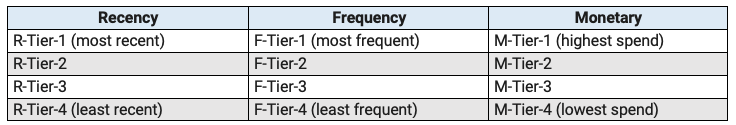

In [118]:
# Arguments for Recency (Lower is better)(x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

# Arguments for Frquency and Monetary (higher is better) (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [119]:
# Display RFM segmentation table

# Calculate R_Quartile, F_Quartile and M_Quartile scores for each customer 

rfm_seg = rfm
rfm_seg['R_Quartile'] = rfm_seg['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_seg['F_Quartile'] = rfm_seg['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_seg['M_Quartile'] = rfm_seg['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

# Combine these three scores into one "RFMScore"

rfm_seg['RFMScore'] = rfm_seg.R_Quartile.map(str) \
                            + rfm_seg.F_Quartile.map(str) \
                            + rfm_seg.M_Quartile.map(str)
rfm_seg.head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,325,2,0.00,4,4,4,444
1,12347.0,1,182,4310.00,1,1,1,111
2,12348.0,74,31,1797.24,3,3,1,331
3,12349.0,18,73,1757.55,2,2,1,221
4,12350.0,309,17,334.40,4,4,3,443


<a id='results1'></a>
## Results and Interpretations of RFM Analysis

Finally, select groups of customers to whom specific types of communications will be sent, based on the RFM segments in which they appear. It is helpful to assign names to segments of interest.

__Best Customers__: Bought most recently, most often, and spend the most

In [120]:
rfm_seg[rfm_seg['RFMScore']=='111'].sort_values('Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
1420,14258.0,8,112,12650.08,1,1,1,111
2438,15640.0,3,495,12433.34,1,1,1,111
561,13078.0,0,380,12432.28,1,1,1,111
2329,15498.0,0,523,12396.46,1,1,1,111
277,12682.0,3,525,12288.22,1,1,1,111
3090,16525.0,1,200,11895.57,1,1,1,111
3671,17340.0,8,424,11891.18,1,1,1,111
1675,14607.0,15,114,11341.10,1,1,1,111
1370,14194.0,4,604,11216.75,1,1,1,111
1883,14895.0,7,506,11020.26,1,1,1,111


List key segments:

In [121]:
print('Best Customers:',len(rfm_seg[rfm_seg['RFMScore']=='111']))

print('New Customers: ',len(rfm_seg[rfm_seg['R_Quartile']==1])) #New customers

print('Loyal Customers: ',len(rfm_seg[rfm_seg['F_Quartile']==1])) #Loyal customers = Buy most frequently

print('Big Spenders: ',len(rfm_seg[rfm_seg['M_Quartile']==1])) #Spend the most

print('Lost Cheap Customers: ',len(rfm_seg[rfm_seg['RFMScore']=='444'])) #Last purchased long ago, purchased few, and spent little

Best Customers: 430
New Customers:  1122
Loyal Customers:  1065
Big Spenders:  1073
Lost Cheap Customers:  384


### Interpretations of initial analyses:

Table 2.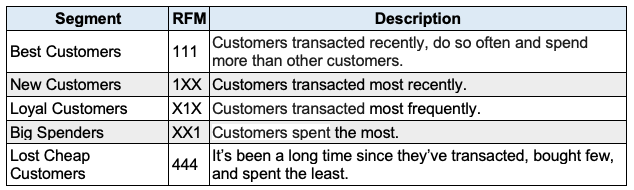

In [122]:
# Further analyze 

print('High-spending New Customers: ', len(rfm_seg[rfm_seg['RFMScore']=='141']+rfm_seg[rfm_seg['RFMScore']=='142']))

print('Lowest-Spending Active Loyal Customers  : ', len(rfm_seg[rfm_seg['RFMScore']=='113']+rfm_seg[rfm_seg['RFMScore']=='114']))

print('Churned Best Customers : ', len(rfm_seg[rfm_seg['RFMScore']=='411'] + rfm_seg[rfm_seg['RFMScore']=='412'] + rfm_seg[rfm_seg['RFMScore']=='421']+ rfm_seg[rfm_seg['RFMScore']=='422']))

High-spending New Customers:  19
Lowest-Spending Active Loyal Customers  :  21
Churned Best Customers :  120


### Interpretations of further analyses:

Now marketers know the customer segments, next step is to further segment customers and craft specific messaging that is tailored for each customer group. By focusing on the behavioral patterns of particular groups, RFM marketing allows marketers to communicate with customers in a much more effective manner.

Table 3.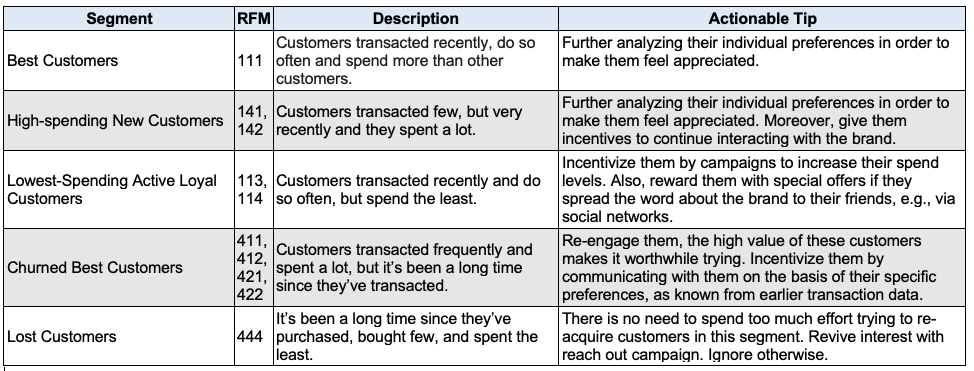


Furthermore, more sophisticated and less manual approaches such as k-means cluster analysis can be also performed, resulting in clusters of customers with more homogeneous characteristics. Therefore, k-means clustering will be implemented here. 

### Normalize the dataset 

Rescale the data so that the dataset has a comparable scale; there are two common ways of rescaling:

- Min-Max scaling 
> MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge

- Standardisation scaling => StandardScaler (mean-0, sigma-1)
> StandardScaler is useful for the features that follow a Normal distribution. 
StandardScaler follows Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance. Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution, which makes it easier to learn the weights.


Here, __Standardisation Scaling__ will be applied.

In [123]:
# Rescale the attributes
rfm_df = rfm[['Recency', 'Frequency','Monetary']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4290, 3)

In [124]:
# Display the RFM model again 

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Recency', 'Frequency','Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,2.300765,-0.749872,-0.738835
1,-0.906903,1.041232,1.796627
2,-0.184188,-0.461305,0.318435
3,-0.738600,-0.043381,0.295086
4,2.142362,-0.600614,-0.542116


<a id='segmentation2'></a>
## Customer segments with K-Means Clustering

K-means clustering is one of the popular unsupervised machine learning algorithms.

The algorithm works as follows:

- __Step 1__: Choose the number of clusters k  
- __Step 2__: Select k random points from the data as centroids
- __Step 3__: Calculate the distance between each data point and cluster centers. And assign the data point to the cluster center whose distance from the cluster center is minimum of all the cluster centers.
- __Step 4__: Recompute the centroids of newly formed clusters
- __Step 5__: Repeat steps 3 and 4


K-Means clustering implementation: 

- Select the number of clusters k
- Calculated the within cluster sum of squares (WCSS) for each clustering soluiton and use the WCSS values to decide the best number of clusters using elbow method.

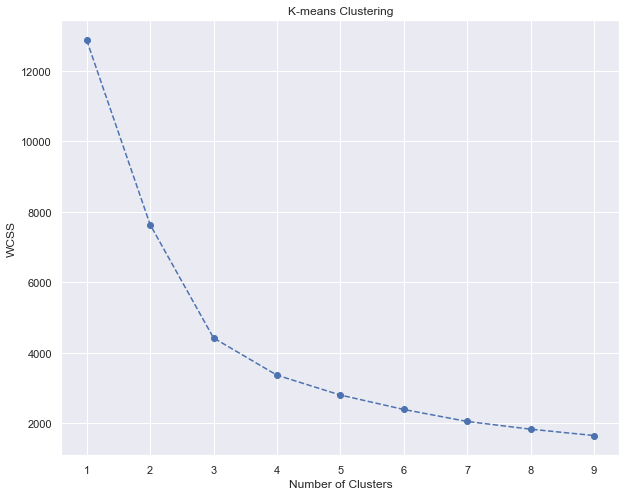

In [125]:
# Perform K-means clustering from 1 to 10 clusters
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, init = 'k-means++') # k-means++ algorithm is used to find the best starting points for the centroid.
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Within Cluster Sum of Squares for the different number of clusters
plt.figure(figsize = (10,8))
plt.plot (range(1,10),wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

It seems the optimal number of clusters is three (__k=3__) ("elbow" of the line ) 

In [126]:
# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters = 3, init = 'k-means++')

# Fit the model into the standardized dataset
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

In [127]:
# Label these clusters 
kmeans.labels_

array([1, 0, 2, ..., 2, 0, 2], dtype=int32)

In [128]:
# Assign clustering labels into the data frame 
rfm['ClusterID'] = kmeans.labels_

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,ClusterID
0,12346.0,325,2,0.00,4,4,4,444,1
1,12347.0,1,182,4310.00,1,1,1,111,0
2,12348.0,74,31,1797.24,3,3,1,331,2
3,12349.0,18,73,1757.55,2,2,1,221,2
4,12350.0,309,17,334.40,4,4,3,443,1


=> According to the above results, it seems the importance of customers is: ClusterID=0 => ClusterID=1 => ClusterID=2

Therefore, now we label ClusterID=0 as __"Valuable customers"__, ClusterID=1 as __"Observing"__ , and ClusterID=2 as __"At risk"__.

In [143]:
# Label each of the data points with cluster name
rfm['Labels'] = rfm['ClusterID'].map({0:'Valuable customers', 
                                      1:'Obeserving',
                                      2:'At risk'})

<a id='results2'></a>
## Results and Interpretation of K-means Clustering

In [144]:
rfm_counts = rfm.groupby('ClusterID').size().reset_index(name='Counts')
rfm_counts['percent'] = ((rfm_counts['Counts'] / 
                  rfm_counts['Counts'].sum()) * 100).round(1)
rfm_counts 

,ClusterID,Counts,percent
0,0,500,11.7
1,1,1068,24.9
2,2,2722,63.4


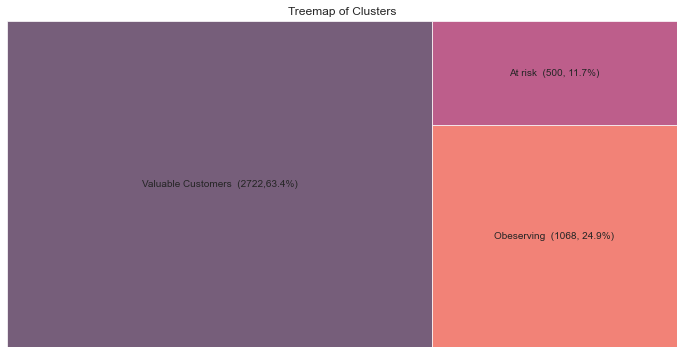

In [145]:
# Create a treemap
plt.figure(figsize=(12,6))
sq.plot(sizes=[2722,1068,500], label=["Valuable Customers  (2722,63.4%)", "Obeserving  (1068, 24.9%)", "At risk  (500, 11.7%)"],
        alpha=.7)

# Labels 
plt.title('Treemap of Clusters')
plt.axis('off')
plt.show()

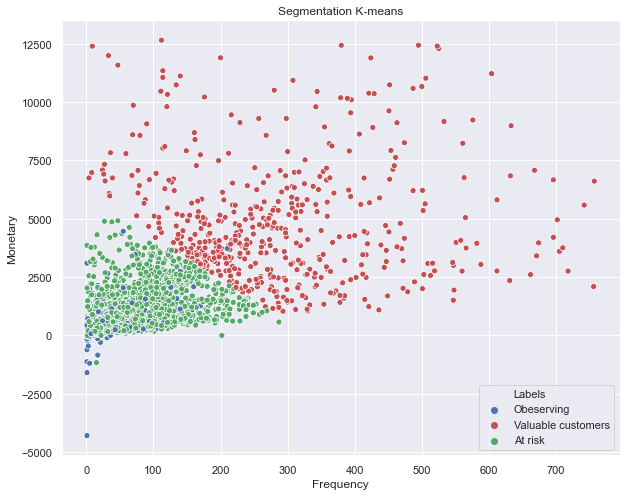

In [146]:
# Scatterplot for visualization
x_axis = rfm['Frequency']
y_axis = rfm['Monetary']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = rfm['Labels'], palette = ['b', 'r', 'g'])
plt.title('Segmentation K-means')
plt.show()

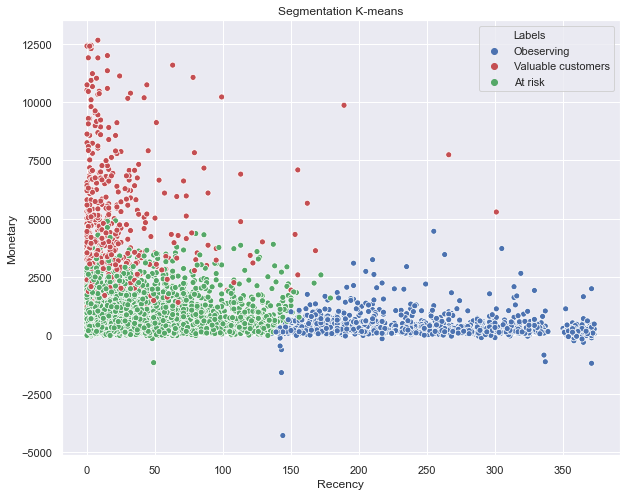

In [147]:
# Scatterplot for visualization
x_axis = rfm['Recency']
y_axis = rfm['Monetary']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = rfm['Labels'], palette = ['b', 'r', 'g'])
plt.title('Segmentation K-means')
plt.show()

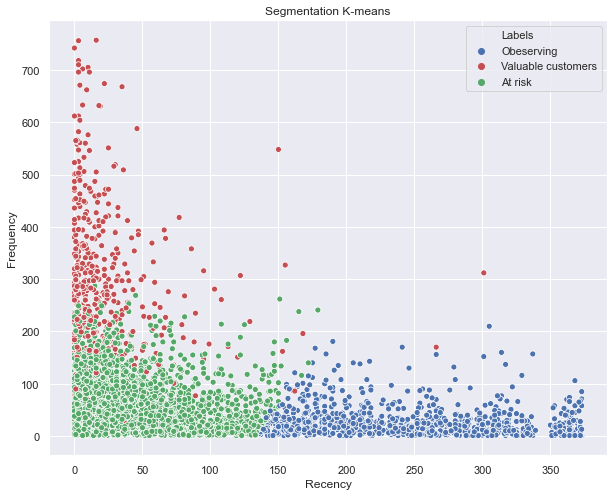

In [148]:
# Scatterplot for visualization
x_axis = rfm['Recency']
y_axis = rfm['Frequency']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = rfm['Labels'], palette = ['b', 'r', 'g'])
plt.title('Segmentation K-means')
plt.show()

In [135]:
rfm.describe()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,ClusterID
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,92.604429,77.359674,1255.936448,2.485315,2.512354,2.500000,1.517949
std,101.019718,100.508402,1700.085952,1.128240,1.124127,1.118373,0.694903
min,0.000000,1.000000,-4287.630000,1.000000,1.000000,1.000000,0.000000
25%,17.000000,17.000000,289.352500,1.000000,2.000000,1.250000,1.000000
50%,50.000000,40.000000,632.220000,2.000000,3.000000,2.500000,2.000000
75%,145.000000,97.000000,1516.785000,3.000000,4.000000,3.750000,2.000000
max,373.000000,757.000000,12650.080000,4.000000,4.000000,4.000000,2.000000


### Examine the first cluster "Valuable Customers"

In [149]:
rfm.loc[rfm['ClusterID'] == 0]

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,ClusterID,Labels
1,12347.0,1,182,4310.00,1,1,1,111,0,Valuable customers
10,12357.0,32,131,6207.67,2,1,1,211,0,Valuable customers
12,12359.0,7,254,6245.53,1,1,1,111,0,Valuable customers
15,12362.0,2,274,5154.58,1,1,1,111,0,Valuable customers
20,12370.0,50,167,3545.69,2,1,1,211,0,Valuable customers
...,...,...,...,...,...,...,...,...,...,...
4326,18225.0,2,286,5361.02,1,1,1,111,0,Valuable customers
4327,18226.0,38,245,5192.10,2,1,1,211,0,Valuable customers
4330,18229.0,11,164,7276.90,1,1,1,111,0,Valuable customers
4361,18272.0,2,170,3064.78,1,1,1,111,0,Valuable customers


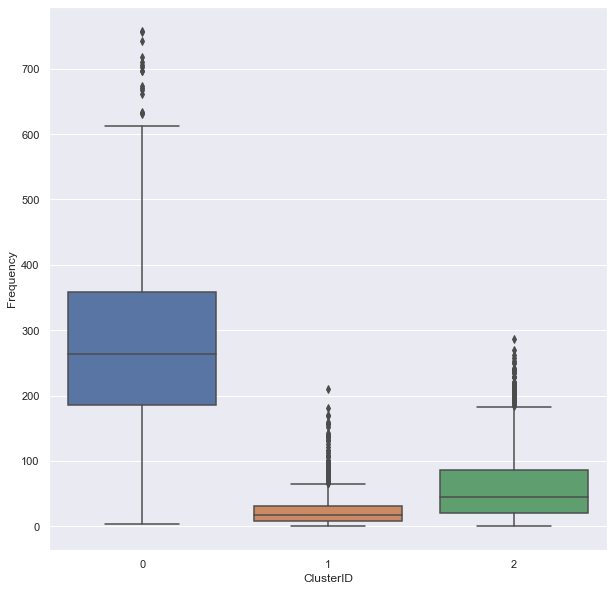

In [150]:
# Plot ClusterID vs Frequency

sns.boxplot(x='ClusterID', y='Frequency', data=rfm)

__Interpretation:__

- Customer with ClusterID = 0 are frequent buyers (Frequency: ClusterID=0 > ClusterID=1 > ClusterID=2)
- Customers with ClusterID =0 have RFMScore = 111 & 211 which means they spent the most and most often, and they are recent buyers. 

### Examine the second cluster "Obeserving"

In [151]:
rfm.loc[rfm['ClusterID'] == 1]

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,ClusterID,Labels
0,12346.0,325,2,0.00,4,4,4,444,1,Obeserving
4,12350.0,309,17,334.40,4,4,3,443,1,Obeserving
6,12353.0,203,4,89.00,4,4,4,444,1,Obeserving
7,12354.0,231,58,1079.40,4,2,2,422,1,Obeserving
8,12355.0,213,13,459.40,4,4,3,443,1,Obeserving
...,...,...,...,...,...,...,...,...,...,...
4350,18256.0,354,4,-50.10,4,4,4,444,1,Obeserving
4355,18262.0,139,13,149.48,3,4,4,344,1,Obeserving
4359,18269.0,357,8,138.90,4,4,4,444,1,Obeserving
4367,18280.0,277,10,180.60,4,4,4,444,1,Obeserving


In [152]:
rfm.loc[rfm['ClusterID'] == 1].sort_values('Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,ClusterID,Labels
1974,15032.0,255,55,4464.100,4,2,1,421,1,Obeserving
2566,15808.0,305,210,3724.770,4,1,1,411,1,Obeserving
3598,17230.0,263,73,3466.670,4,2,1,421,1,Obeserving
1195,13952.0,210,138,3246.091,4,1,1,411,1,Obeserving
603,13135.0,196,1,3096.000,4,4,1,441,1,Obeserving
335,12754.0,235,65,2949.120,4,2,1,421,1,Obeserving
3794,17504.0,205,140,2745.280,4,1,1,411,1,Obeserving
1546,14439.0,319,32,2661.240,4,3,1,431,1,Obeserving
230,12625.0,211,91,2614.320,4,2,1,421,1,Obeserving
2134,15235.0,217,143,2247.510,4,1,1,411,1,Obeserving


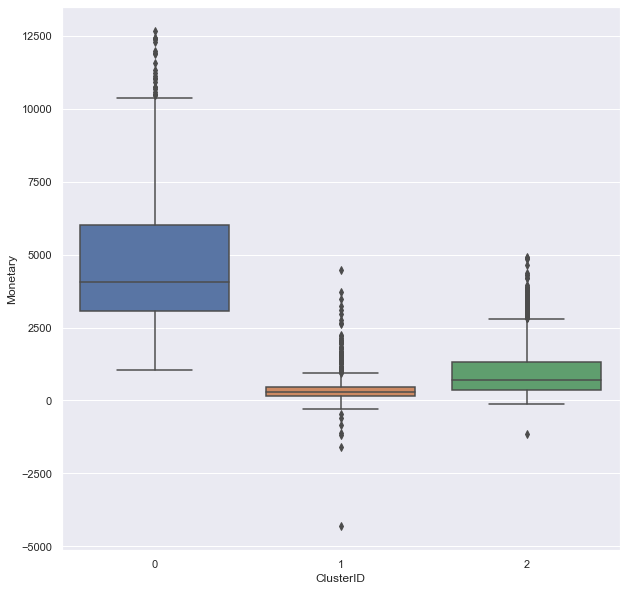

In [153]:
# Plot ClusterID vs Monetary
sns.boxplot(x='ClusterID', y='Monetary', data=rfm)

__Interpretation:__

- Customers within ClusterID = 1 buy more compared to customers in other two clusters (Monetary: Cluster_id=0 > Cluster_id= > Cluster_id=2)
- Customers with ClusterID = 1 have RFMScore XX1 (XX = 1,2 or 3), which means they bought the most. 

### Examine the third cluster "At risk"

In [154]:
rfm.loc[rfm['ClusterID'] == 2]

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,ClusterID,Labels
2,12348.0,74,31,1797.24,3,3,1,331,2,At risk
3,12349.0,18,73,1757.55,2,2,1,221,2,At risk
5,12352.0,35,95,1545.41,2,2,1,221,2,At risk
9,12356.0,22,59,2811.43,2,2,1,221,2,At risk
11,12358.0,1,19,1168.06,1,3,2,132,2,At risk
...,...,...,...,...,...,...,...,...,...,...
4364,18276.0,20,16,323.36,2,4,3,243,2,At risk
4365,18277.0,57,9,97.63,3,4,4,344,2,At risk
4366,18278.0,73,9,173.90,3,4,4,344,2,At risk
4369,18282.0,7,13,176.60,1,4,4,144,2,At risk


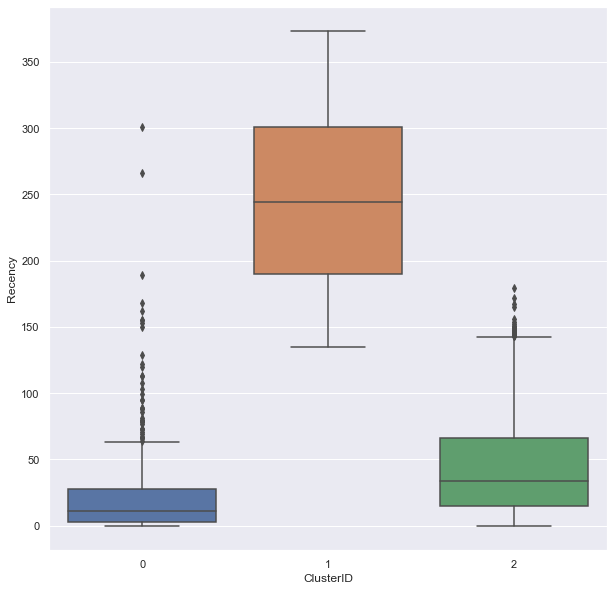

In [155]:
# Plot ClusterID vs Recency
sns.boxplot(x='ClusterID', y='Recency', data=rfm)

__Interpretation:__

- Customers with ClusterID = 2 are recent buyers (Customers with ClusterID =0 purchased recenter than customers with ClusterID=1, and customers with ClusterID=1 purchased recenter than customers with ClusterID=2)
- Customers with ClusterID = 2 have RFMScore without 1, which means they are less recent/frequent buyer and they bought fewer. 

###  Conclusion (prioritize by: more => less ): 

- Recency: ClusterID=0 => ClusterID=1 => ClusterID=2

- Frequency: ClusterID=0 => ClusterID=1 => ClusterID=2

- Monetary: Cluster_ID=0 => Cluster_ID=1 => Cluster_ID=2

The final result shows customers in ClusterID=0 are more valuable than other two clusters; this further validate the initial result labelling customers with ClusterID=0 as "Valuable Customers", customers with ClusterID=1 as "Observing" and ClusterID=3 as "At Risk". 